In [1]:
import os
import cv2
import numpy as np
import torch
import dlib
from imutils import face_utils
from basicsr.archs.rrdbnet_arch import RRDBNet
from basicsr.utils.download_util import load_file_from_url
from realesrgan import RealESRGANer
from realesrgan.archs.srvgg_arch import SRVGGNetCompact
import torch.nn as nn
from torch.utils.data import Dataset
from albumentations.pytorch import ToTensorV2
import albumentations as A
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


detector = None
predictor = None
GAN_MODEL = None
IRIS_MODEL = None


In [5]:

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
eye_modelgan_path = "/home/nipun/Music/Real-ESRGAN/experiments/net_g_30000.pth"

eye_segmentation_path = "/home/nipun/Documents/Uni_Malta/LuminEye/LuminEye-Experiments/U2net/u2net_multiclass_epoch_200_batch_2/Miche_model_2023_01_09_23:22:49_val_iou0.907.pt"

IRIS_MODEL, RESIZE_AMT = load_model(
    model_path=eye_segmentation_path, model_input_size=512)


GAN_MODEL = irisGanModel(model_path=eye_modelgan_path)


In [4]:

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)  # ( 68,2)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)  # [0,0]--> (x,y)

    # return the list of (x, y)-coordinates
    return coords


def rect_to_bb(rect):
    # we will take the bounding box predicted by dlib library
    # and convert it into (x, y, w, h) where x, y are coordinates
    # and w, h are width and height
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    return (x, y, w, h)


def captureFaceLandmarks(image, detector, predictor):
    """Get the coordinates of the facelandmarks

    Returns:
        _cv2_image_: _BGR image_
    """

    # Face Bounding Box
    rects = detector(image, 1)[0]  # --> (x,y,w,h)

    x, y, w, h = rect_to_bb(rects)

    if w * h > 2000:

        shape = predictor(image, rects)
        shape_arr = shape_to_np(shape)

    return shape_arr


def findSymX(shape_arr):
    """Return average symmetric axis x coordinate

    Args:
        shape_arr (_np.numpy_): _FaceLandMark Coordinates_

    Returns:
        _float32_: _x coordinate of symmetric x axis_
    """
    x_coord = [x for x, y in shape_arr[27:31]]
    x_coord.extend(
        (
            shape_arr[33][0],
            shape_arr[51][0],
            shape_arr[62][0],
            shape_arr[66][0],
            shape_arr[57][0],
            shape_arr[8][0],
        )
    )
    return sum(x_coord)/len(x_coord)


def calculateParameters(shape_array):
    """Return meanWidth,piyotY and SymmX along with Radius of the face

    Args:
        shape_array (_numpy_): _FaceLandMark locations_
    """

    meanWidth = shape_array[16][0] - shape_array[0][0]

    symmAxis_x = findSymX(shape_arr=shape_array)

    piyot_y = shape_array[33][1]

    return meanWidth, symmAxis_x, piyot_y, meanWidth/2


def irisGanModel(model_path, dni_weight=None, tile=0, tile_pad=10,
                 pre_pad=0, fp32=True, gpu_id=0, netscale=2):

    model = SRVGGNetCompact(num_in_ch=3, num_out_ch=3,
                            num_feat=64, num_conv=16, upscale=2, act_type='prelu')

    return RealESRGANer(
        scale=netscale,
        model_path=model_path,
        dni_weight=dni_weight,
        model=model,
        tile=tile,
        tile_pad=tile_pad,
        pre_pad=pre_pad,
        half=not fp32,
        gpu_id=gpu_id)


def cropped_image(img, shape_array, padded_amt=20, enhance=True):
    """Cropped eye region and enhance it according to the requirement

    Args:
        img (__numpy__): _Original Image_
        shape_array (_numpy_): _FaceLandMark locations_
        padded_amt (int, optional): _padding size_. Defaults to 20.
        enhance (bool, optional): _applying SISR_. Defaults to True.
    """

    Leye = {"top_left": shape_array[18], "bottom_right": shape_array[28]}

    Reye = {"top_left": [shape_array[28][0], shape_array[25][1]],
            "bottom_right": [shape_array[25][0], shape_array[28][1]]}

    left_eye = img[Leye["top_left"][1]:Leye["bottom_right"][1] +
                   padded_amt, Leye["top_left"][0]:Leye["bottom_right"][0]-padded_amt]

    right_eye = img[Reye["top_left"][1]:Reye["bottom_right"][1] +
                    padded_amt, Reye["top_left"][0]+padded_amt:Reye["bottom_right"][0]]

    if enhance:
        left_eye, _ = GAN_MODEL.enhance(left_eye)
        right_eye, _ = GAN_MODEL.enhance(right_eye)

    return left_eye, right_eye,Leye,Reye


def load_model(model_path, model_input_size):
    """Load Segmentation model

    Args:
        model_path (_str_): _model path_
        model_input_size (_int_): _Input size of the model_

    Returns:
        _torch model_: _U2NET model_
    """

    model = torch.load(model_path)

    model.eval()

    return model, model_input_size


def imgTransform(image, resize_amt):
    """ Transform numpy images to Torch tensors

    Args:
        image (_numpy_): _cropped_eye_region_
        resize_amt (_int_): _Input Resize for the image_

    Returns:
        _torch.float32_: _Transformed image tensor_
    """

    transform = A.Compose([
        A.Resize(resize_amt, resize_amt),
        A.augmentations.transforms.Normalize(
            mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2()
    ])

    return transform(image=image)["image"]


def predict_image_masku2net(model, image):
    
    image = imgTransform(image[:,:,::-1], RESIZE_AMT)

    image = image.to(device)

    # print(image)

    with torch.no_grad():

        softmax = nn.Softmax(dim=1)
        image = image.unsqueeze(0)

        model_output, _, _, _, _, _, _ = model(image)

        output = softmax(model_output)

        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked




def decode_segmap(temp,n_classes=3):
    
    
    colors = [ [  0,   0,   0],[0,255,0],[0,0,255]]
    label_colours = dict(zip(range(n_classes), colors))
    #convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb


def drawContours(frame,pred_mask,h,w,margin):
    """Draw Iris and Pupil Contours on Original Image

    Args:
        frame (_numpy_): _original image frame_
        pred_mask (_torch.float32_): _prediction from model_
        h (_int_): _cropped eye image height_
        w (_int_): _cropped eye image height_
        margin (_dic_): _Eye Top Left x and y coordinates
        
        
    """
    
    
    pred_image = decode_segmap(pred_mask) * 255
    pred_image = pred_image.astype(np.uint8)
    edge_detected_image = cv2.Canny(pred_image, 0, 200)
    
    contours, hierarchy = cv2.findContours(edge_detected_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    max_area = {}
    
    for contour in contours:
    
        approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
        area = cv2.contourArea(contour)
        # print(area)
        if ((len(approx) > 8) & (len(approx) < 23) & (area > 30) ):
            
            
            max_area[area] = contour
            
    x = sorted(max_area,key = lambda x:x)

    print(x)

    max_contour = max_area[x[-1]]
    min_contour = max_area[x[1]]
    
    
    for coords in min_contour:
    
        coords[0][0] = margin["top_left"][0] + ((coords[0][0]/RESIZE_AMT) * w)
        coords[0][1] = margin["top_left"][1] + ((coords[0][1]/RESIZE_AMT) * h)
    for coords in max_contour:
    
        coords[0][0] = margin["top_left"][0] + ((coords[0][0]/RESIZE_AMT) * w)
        coords[0][1] = margin["top_left"][1] + ((coords[0][1]/RESIZE_AMT) * h)
        
    cv2.drawContours(frame,[max_contour],0,(0,0,255),1)
    cv2.drawContours(frame,[min_contour],0,(0,255,0),1)
    
    return frame








In [6]:
img_path = "/home/nipun/Pictures/my_eye.png"

image = cv2.imread(img_path)

In [7]:
shape_array = captureFaceLandmarks(image , detector, predictor)
meanWidth, symmAxis_x, piyot_y, R = calculateParameters(shape_array)

In [8]:
left_eye, right_eye,Leye,Reye = cropped_image(image, shape_array)


print(left_eye.shape) # (103, 121, 3) # (206, 242, 3)

print(right_eye.shape) # (100, 125, 3)  # (200, 250, 3)

(206, 242, 3)
(200, 250, 3)


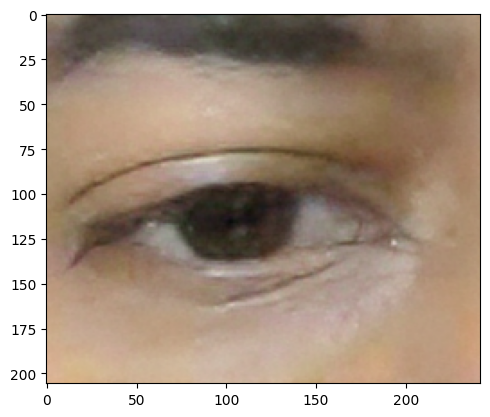

In [9]:
plt.imshow(left_eye[:,:,::-1])

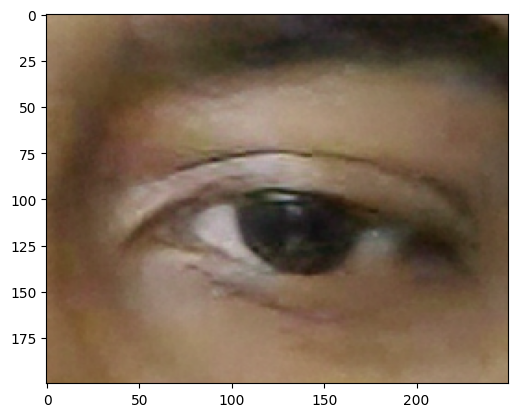

In [10]:
plt.imshow(right_eye[:,:,::-1])

In [11]:
pred_l_eye = predict_image_masku2net(IRIS_MODEL,left_eye)

/home/nipun/.local/lib/python3.10/site-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [12]:
pred_r_eye  = predict_image_masku2net(IRIS_MODEL, right_eye)

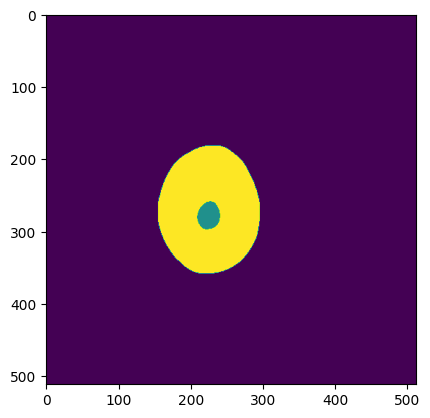

In [13]:
plt.imshow(pred_l_eye)

torch.Size([512, 512])


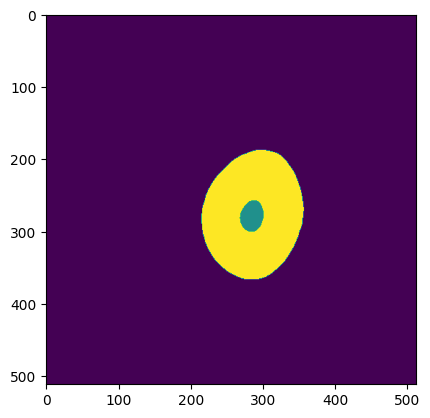

In [14]:
plt.imshow(pred_r_eye)


print(pred_r_eye.shape)

In [15]:
pred_image = decode_segmap(pred_r_eye) * 255

pred_image = pred_image.astype(np.uint8)
# print()

# print(pred_image.shape)
edge_detected_image = cv2.Canny(pred_image, 0, 200)

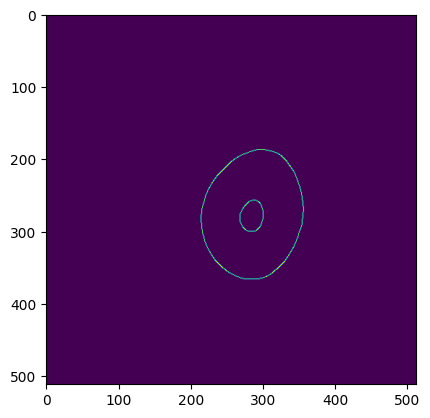

In [16]:
plt.imshow(edge_detected_image)

In [17]:
contours, hierarchy = cv2.findContours(edge_detected_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [18]:
max_area = {}


for contour in contours:
    
    approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
    area = cv2.contourArea(contour)
    # print(area)
    if ((len(approx) > 8) & (len(approx) < 23) & (area > 30) ):
        
        
        max_area[area] = contour
        

x = sorted(max_area,key = lambda x:x)


max_contour = max_area[x[-1]]
min_contour = max_area[x[1]]

In [19]:
print(x)

h,w = right_eye.shape[0]/2,right_eye.shape[1]/2

print(h,w)

[1070.5, 1089.5, 19362.0, 19446.0]
100.0 125.0


In [20]:
for coords in max_contour:
    
    coords[0][0] = Reye["top_left"][0]+20 + ( (coords[0][0]/512) * w)
    coords[0][1] = Reye["top_left"][1] +((coords[0][1]/512) * h)

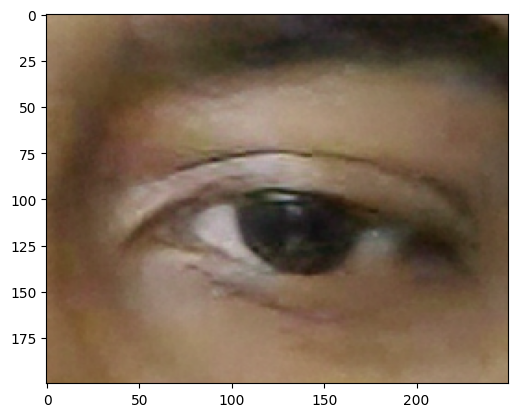

In [21]:
plt.imshow(right_eye[:,:,::-1])

In [22]:
for coords in min_contour:
    
    coords[0][0] = Reye["top_left"][0]+20 +((coords[0][0]/512) * w)
    coords[0][1] = Reye["top_left"][1] +((coords[0][1]/512) * h)

In [23]:
cv2.drawContours(image,[min_contour],0,(0,255,0),1)
cv2.drawContours(image,[max_contour],0,(0,255,0),1)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [225, 223, 224],
        [225, 223, 224],
        [225, 223, 224]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [225, 223, 224],
        [225, 223, 224],
        [225, 223, 224]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [225, 223, 224],
        [225, 223, 224],
        [225, 223, 224]],

       ...,

       [[ 36,  33,  32],
        [ 36,  33,  32],
        [ 36,  33,  32],
        ...,
        [ 36,  33,  32],
        [ 36,  33,  32],
        [ 36,  33,  32]],

       [[ 36,  33,  32],
        [ 36,  33,  32],
        [ 36,  33,  32],
        ...,
        [ 36,  33,  32],
        [ 36,  33,  32],
        [ 36,  33,  32]],

       [[ 36,  33,  32],
        [ 36,  33,  32],
        [ 36,  33,  32],
        ...,
        [ 36,  33,  32],
        [ 36,  33,  32],
        [ 36,  33,  32]]

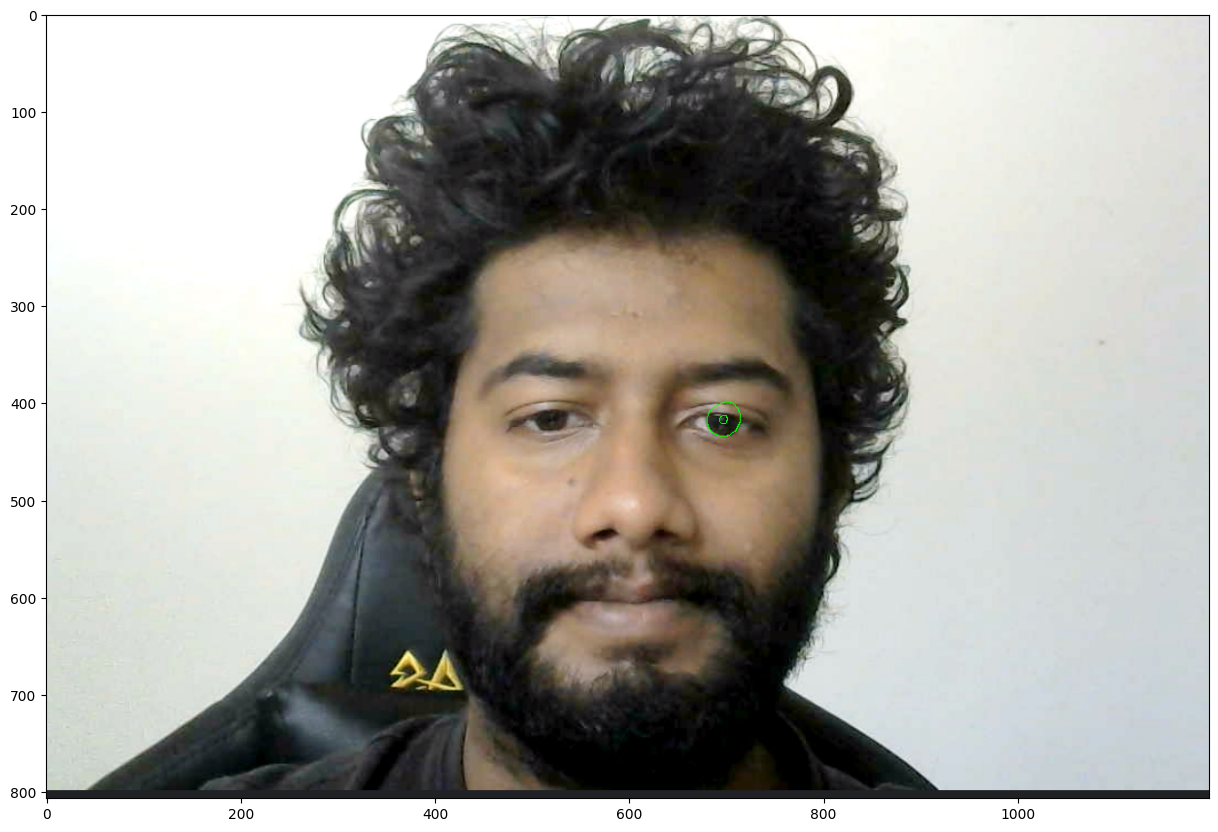

In [24]:
plt.figure(figsize=(15,15))
plt.imshow(image[:,:,::-1])

In [ ]:
def main(visualize_iris=True):

    vid = cv2.VideoCapture(0)

    frameCounter = 0

    while True:

        ret, frame = vid.read()
        
        
        

        shape_array = captureFaceLandmarks(frame, detector, predictor)

        meanWidth, symmAxis_x, piyot_y, R = calculateParameters(shape_array)

        left_eye, right_eye,Leye,Reye = cropped_image(frame, shape_array)
        
        pred_l_eye,pred_r_eye = predict_image_masku2net(IRIS_MODEL,left_eye),predict_image_masku2net(IRIS_MODEL, right_eye)
        
        
        if visualize_iris:
            frame = drawContours(frame,pred_l_eye,h=left_eye.shape[0],w=left_eye.shape[1],margin=Leye)
            frame = drawContours(frame,pred_r_eye,h=right_eye.shape[0],w=right_eye.shape[1],margin=Reye)
        
        
        
        
        
        

        print("Mean Width: ", meanWidth)
        print("Symm Axis: ", symmAxis_x)
        print("Piyot Y:", piyot_y)
        print("Radius of the face: ", R)

        frameCounter += 1

        cv2.imshow("Frame", frame)

        if cv2.waitKey(1) and 0xFF == ord('q'):
            break

    vid.release()
    cv2.destroyAllWindows()

In [1]:
import numpy as np

In [2]:
x = np.arange(12).reshape(-1,3,2)

In [3]:
x

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5]],

       [[ 6,  7],
        [ 8,  9],
        [10, 11]]])

In [4]:
np.sum(x,axis=0)

array([[ 6,  8],
       [10, 12],
       [14, 16]])

In [5]:
np.sum(x,axis=1)

array([[ 6,  9],
       [24, 27]])

In [6]:
np.sum(x,axis=2)

array([[ 1,  5,  9],
       [13, 17, 21]])